In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings; warnings.simplefilter('ignore')
import sys
import h5py
import pandas as pd
import seaborn as sns
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_stellarhalo
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models
import evolve as ev
import galhalo as gh
import profiles as profiles
import config as cfg
from matplotlib.lines import Line2D


In [3]:
plt.style.use('../../../SatGen/notebooks/paper1/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches
levelz = [1-0.99, 1-0.95, 1-0.68]

In [4]:
alphas = np.linspace(0.5, 3.5, 7)

In [5]:
S0_a05 = jsm_stellarhalo.load_sample("../../data/SHMR/S0_alpha5.h5")
S0_a1 = jsm_stellarhalo.load_sample("../../data/SHMR/S0_alpha1.h5")
S0_a15 = jsm_stellarhalo.load_sample("../../data/SHMR/S0_alpha15.h5")
S0_a2 = jsm_stellarhalo.load_sample("../../data/fiducial/S0_sample.h5")
S0_a25 = jsm_stellarhalo.load_sample("../../data/SHMR/S0_alpha25.h5")
S0_a3 = jsm_stellarhalo.load_sample("../../data/SHMR/S0_alpha3.h5")
S0_a35 = jsm_stellarhalo.load_sample("../../data/SHMR/S0_alpha35.h5")

In [162]:
samples = [S0_a05, S0_a1, S0_a15, S0_a2, S0_a25, S0_a3, S0_a35]

In [163]:
def analyze_sample(sample, plot=False):

    xvals = np.log10(sample["target_stellarmass"])
    try:
        yvals = np.log10(sample["Mstar_tot"] + sample["Mstar_acc"])
    except KeyError:
        yvals = np.log10(sample["Mstar_ICL"] + sample["Mstar_sat"] + sample["Mstar_acc"])
        
    Mcen_err = np.std(xvals)
    Mtot_err = np.std(yvals)

    rcoeff = jsm_stats.correlation(xvals, yvals)

    if plot:

        # Create figure and axeses explicitly
        fig, axes = plt.subplots(2,2,figsize=(double_textwidth,double_textwidth), sharex="col", sharey="row")

        axes[1,0].axline((8,8), slope=1, color="grey", alpha=0.3, ls="--")
        instance = sns.kdeplot(x=xvals, y=yvals, ax=axes[1, 0], levels=levelz, color="C0", bw_adjust=1.5, linewidths=1)

        sns.kdeplot(xvals, linewidth=1, ax=axes[0, 0], color="C0")
        axes[0,0].text(0.05, 0.05, "$\\sigma_{cen}$="+f"{Mcen_err:.2f} dex", transform=axes[0,0].transAxes, fontsize=12)
        axes[0,0].set_ylim(0,2.5)

        sns.kdeplot(y=yvals, linewidth=1, ax=axes[1, 1], color="C0")
        axes[1,1].text(0.05, 0.05, "$\\sigma_{tot}$="+f"{Mtot_err:.2f} dex", transform=axes[1,1].transAxes, fontsize=12)
        axes[1,1].set_xlim(0,2.5)

        axes[1, 1].set_xlabel("PDF")
        axes[0,1].axis("off")
        axes[1,0].set_xlim(9.2,11.2)
        axes[1,0].set_ylim(6,14)
        axes[0, 0].set_ylabel("PDF")
        axes[1, 0].set_xlabel("log M$_{\\rm cen}$ [M$_{\odot}$]")
        axes[1, 0].set_ylabel("log M$_{\\rm tot}$ [M$_{\odot}$]")

        axes[1,0].text(0.05, 0.05, "$r_{S}$="+f"{rcoeff:.2f}", transform=axes[1,0].transAxes, fontsize=12)

        plt.tight_layout()
        plt.show()
    
    return Mcen_err, Mtot_err, rcoeff

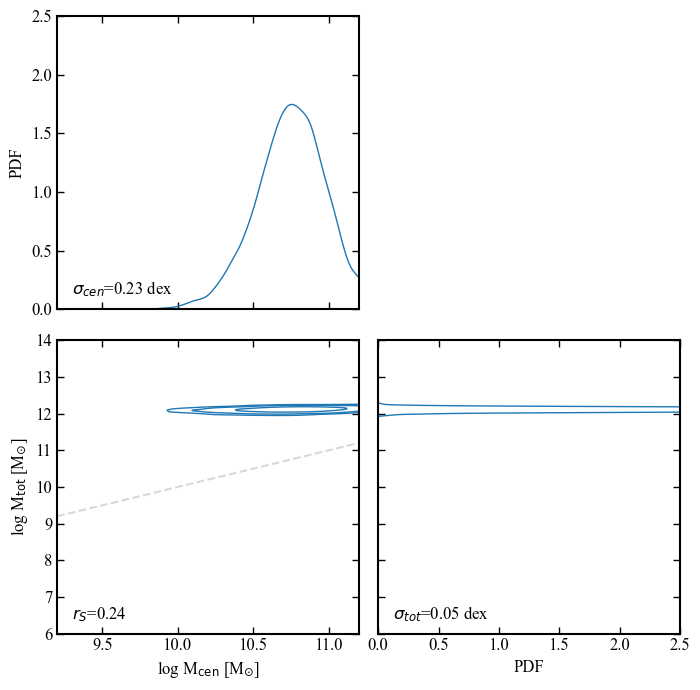

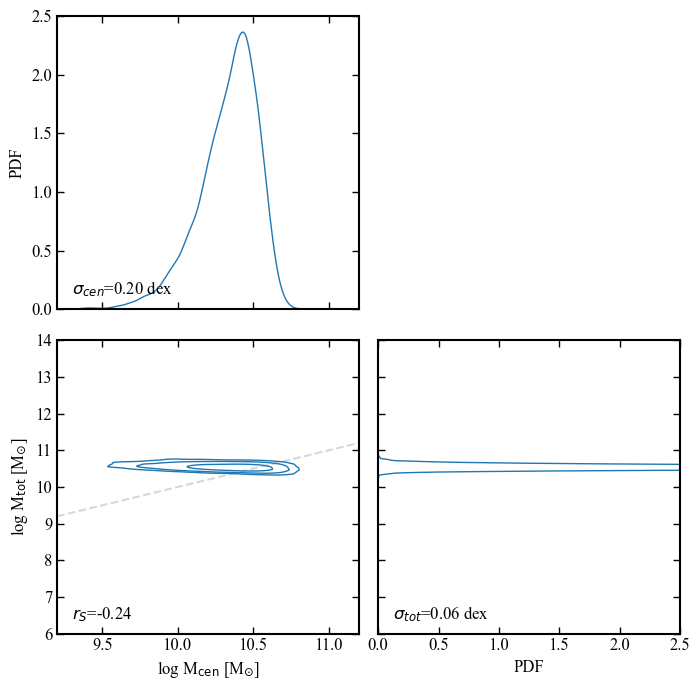

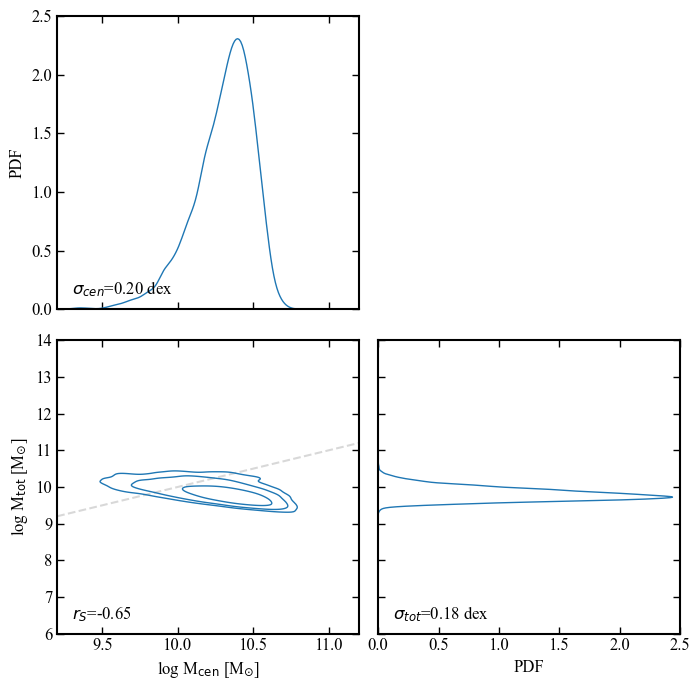

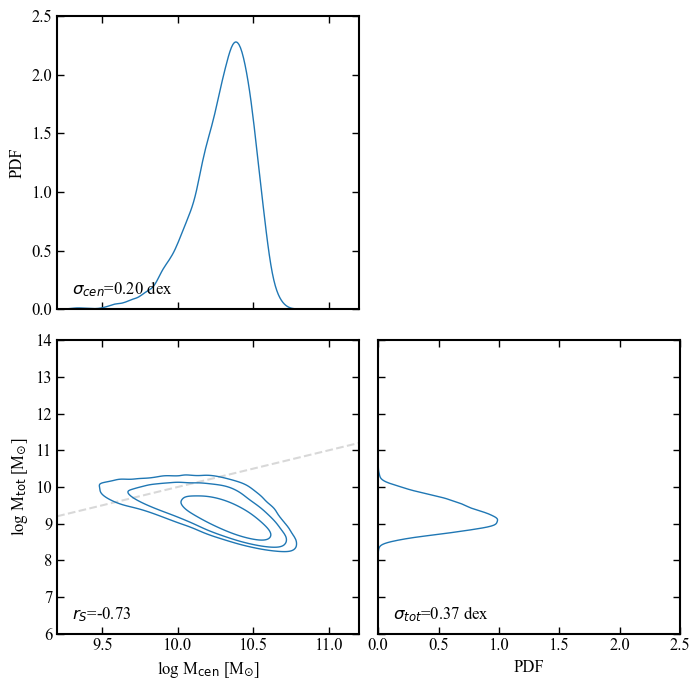

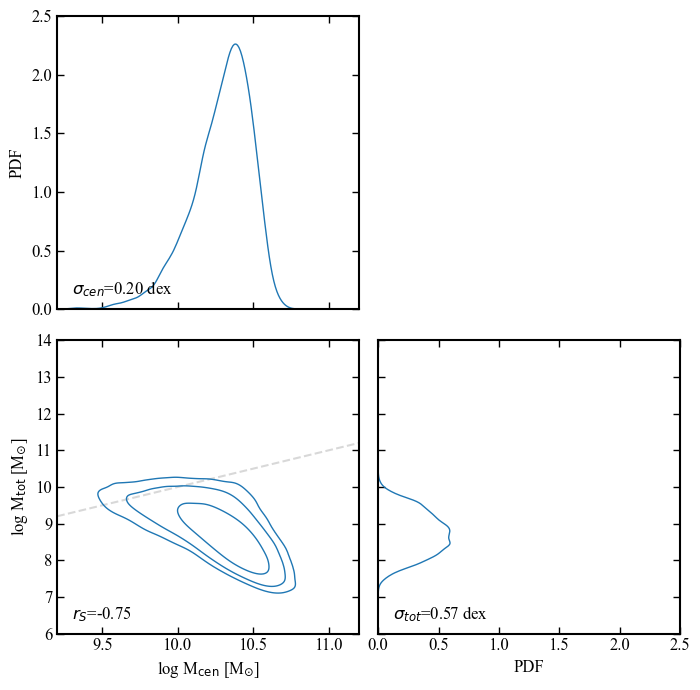

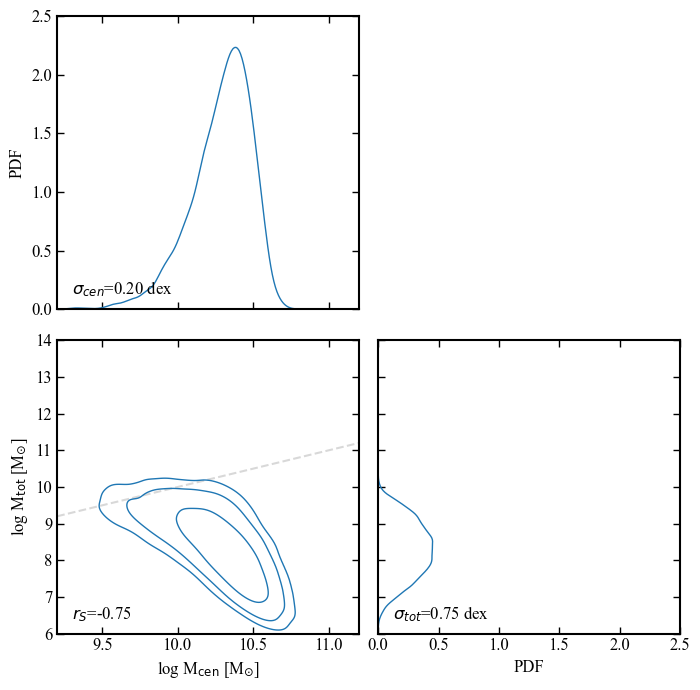

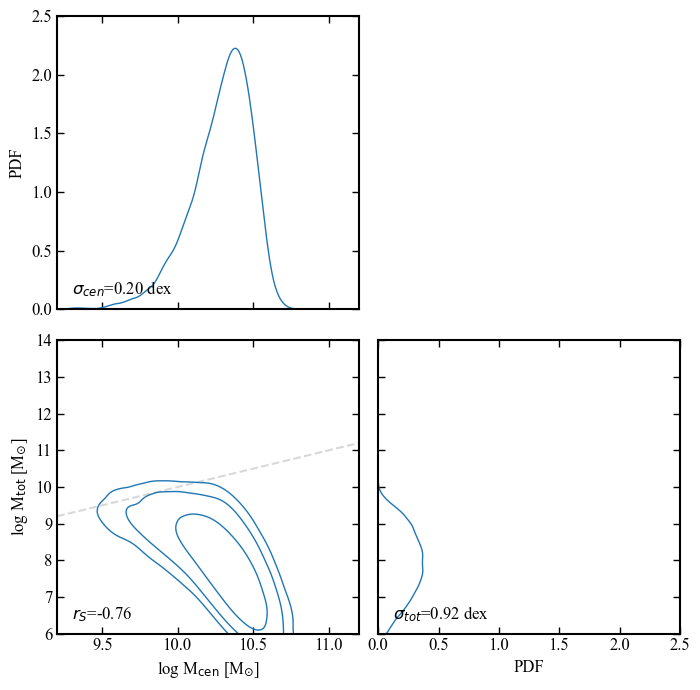

In [164]:
sigmas_cen = []
sigmas_tot = []
rs = []

for i,a in enumerate(alphas):
    Mcen_err, Mtot_err, rcoeff = analyze_sample(samples[i], plot=True)
    sigmas_cen.append(Mcen_err)
    sigmas_tot.append(Mtot_err)
    rs.append(rcoeff)

In [ ]:
def compute_fractions(sample):
    totals = sample.Mstar_acc + sample.Mstar_sat + sample.Mstar_ICL
    Mcentral = np.average(sample.Mstar_acc/totals)
    Msat = np.average(sample.Mstar_sat/totals)
    Micl = np.average(sample.Mstar_ICL/totals)

    return np.array([Micl, Msat, Mcentral])

mat = np.zeros(shape=(7, 3))
for i, sam in enumerate(samples):
    mat[i] = compute_fractions(sam)

In [66]:
smooth = np.linspace(0, 4, 100)

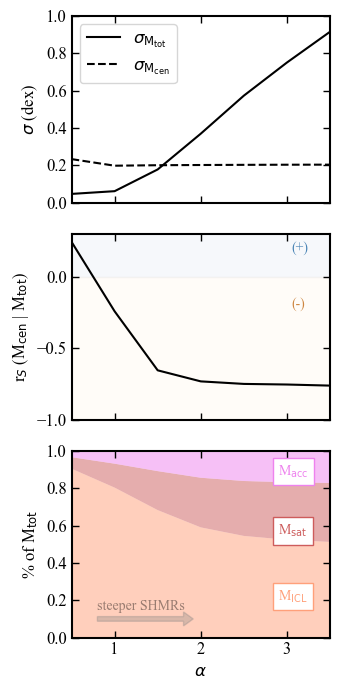

In [161]:
fig, axes = plt.subplots(3,1,figsize=(single_textwidth,double_textwidth), sharex=True)

axes[0].plot(alphas, sigmas_tot, color="k", label="$\\sigma_{\\rm M_{tot}}$")
axes[0].plot(alphas, sigmas_cen, color="k", ls="--",  label="$\\sigma_{\\rm M_{cen}}$")
axes[0].legend()
axes[0].set_ylim(0, 1)
axes[0].set_ylabel("$\\sigma$ (dex)")

axes[1].plot(alphas, rs, color="k")
axes[1].set_ylabel("r$_S$ (M$_{\\rm cen}$ | M$_{\\rm tot}$)")

axes[1].fill_between(smooth, [0]*smooth.shape[0], [1]*smooth.shape[0], color="lightsteelblue", alpha=0.1)
axes[1].fill_between(smooth, [-1]*smooth.shape[0], [0]*smooth.shape[0], color="bisque", alpha=0.1)
axes[1].text(0.85, 0.9, "(+)", color="steelblue", transform=axes[1].transAxes)
axes[1].text(0.85, 0.6, "(-)", color="peru", transform=axes[1].transAxes)
axes[1].set_ylim(-1, 0.3)


axes[2].stackplot(alphas, mat.T, colors=["lightsalmon", "indianred", "violet"], alpha=0.5)
axes[2].text(0.8, 0.2, "M$_{\\rm ICL}$", color="lightsalmon", transform=axes[2].transAxes, bbox=dict(facecolor='white', alpha=1, edgecolor="lightsalmon"))
axes[2].text(0.8, 0.55, "M$_{\\rm sat}$", color="indianred", transform=axes[2].transAxes, bbox=dict(facecolor='white', alpha=1, edgecolor="indianred"))
axes[2].text(0.8, 0.87, "M$_{\\rm acc}$", color="violet", transform=axes[2].transAxes, bbox=dict(facecolor='white', alpha=1, edgecolor="violet"))

axes[2].arrow(0.8, 0.1, 1, 0, width=0.025, color='grey', alpha=0.3)
axes[2].text(0.8, 0.15, "steeper SHMRs", color="k", alpha=0.4)


axes[2].set_xlim(0.5, 3.5)
axes[2].set_ylim(0,1)
axes[2].set_xlabel("$\\alpha$")
axes[2].set_ylabel("% of M$_{\\rm tot}$")

plt.tight_layout()
plt.savefig("../../figures/SHMR_alpha.pdf", bbox_inches="tight")
plt.show()

\textcolor{red}{This shows how changing the slope of the SHMR impacts our model. The top panel shows the scatter in the distribution of $\Mtot$ (which is the sum of $\Mihl$, $\Msat$ and $\Macc$) sharply increases as you sample steeper slopes. Steeper slopes pull the distribution of $\Mtot$ downwards as the majority of subhalos are given relatively little in terms of stellar mass budgets. For shallower slopes, the small scatter is caused by a significant tightening of the distribution towards higher masses where almost all subhalos now contribute a significant amount of stellar material to $\Mtot$. The dashed lines shows the scatter in $\Mcen$ which is set by the in-situ SFR model from the UNIVERSE MACHINE and is therefore insensitive to what we assume about the slope. Importantly, at shallower slopes $\Macc$ becomes such a significant fraction of $\Mcen$ that we see a slight widening.}

\textcolor{red}{The middle panel shows how the rank order correlation coefficient between $\Mcen$ and $\Mtot$ scales with the SHMR. For steeper slopes, the rank order coefficient reflects the distribution of $\Mtot$ stretches towards lower masses. Interestingly it seems to plateau which indicates that this diagnostic would not be good for distinguishing between for example $\alpha = 2$ or $\alpha = 3$.}

\textcolor{red}{This final lower panel shows how the mass budget of $\Mtot$ is distributed across its three components ($\Mihl$, $\Msat$ and $\Macc$). Importantly, these values are all scaled by their respective total such that we don't see the effect of $\Mtot$ decreasing towards steeper slopes. This one is a bit non-intuitive... Assuming that even for the most extreme models ($\alpha=0.5$ for example) our assumption that tidal stripping of stars is set by the dark matter mass loss rate, steeper SHMRs will result in only a handful of massive satellites which do not contribute significantly to the ICL since they have deeper potential wells and relatively short dynamical timescales. This is reflected by the increase in $\Msat$ and $\Macc$. On the other hand, for shallower SHMRs, all of a sudden every tiny subhalo can contribute a relatively large amount of stellar mass to $\Mihl$. Its important to stress that nothing about the DF strength, the tidal stripping model, the merging criteria or the orbits were altered when doing this test. The percentages shown for each value of $alpha$ are the average across the S0 sample. This is simply an effect caused by altering the slope of the SHMR.}